In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [2]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [3]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

In [4]:
sample_a_daily = sample_a.groupby('date').agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={
    'cid': 'users_count',
    'transactions': 'transactions_count',
    'revenue': 'revenue_sum'
    })
sample_a_daily

,date,users_count,transactions_count,revenue_sum
0,2020-11-06,2576,16,1577279
1,2020-11-07,2704,23,1721886
2,2020-11-08,3354,25,846051
3,2020-11-09,3234,18,708830
4,2020-11-10,3022,29,826984
5,2020-11-11,3218,19,1209656
6,2020-11-12,3467,19,607839
7,2020-11-13,3676,36,1338816
8,2020-11-14,3372,30,2659277
9,2020-11-15,3881,27,1189970


In [5]:
sample_b_daily = sample_b.groupby('date').agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={
    'cid': 'users_count',
    'transactions': 'transactions_count',
    'revenue': 'revenue_sum'
    })
sample_b_daily

,date,users_count,transactions_count,revenue_sum
0,2020-11-06,2499,19,996645
1,2020-11-07,2804,19,555499
2,2020-11-08,3291,24,3044842
3,2020-11-09,3062,25,1285836
4,2020-11-10,3072,30,2414726
5,2020-11-11,3208,22,3555727
6,2020-11-12,3494,25,915653
7,2020-11-13,3606,37,1703475
8,2020-11-14,3276,34,2369998
9,2020-11-15,3919,27,1147144


In [17]:
sample_a_daily[sample_a_daily['date'] == '2020-11-08']

,date,users_count,transactions_count,revenue_sum
2,2020-11-08,3354,25,846051


In [6]:
sample_a_daily['cum_users_count'] = sample_a_daily['users_count'].cumsum()
sample_a_daily['cum_transactions_count'] = sample_a_daily['transactions_count'].cumsum()
sample_a_daily['cum_revenue_sum'] = sample_a_daily['revenue_sum'].cumsum()
sample_a_daily['cum_conversion'] = sample_a_daily['cum_transactions_count']/sample_a_daily['cum_users_count'] * 100
sample_a_daily['cum_avg_check'] = sample_a_daily['cum_revenue_sum']/sample_a_daily['cum_transactions_count']

sample_b_daily['cum_users_count'] = sample_b_daily['users_count'].cumsum()
sample_b_daily['cum_transactions_count'] = sample_b_daily['transactions_count'].cumsum()
sample_b_daily['cum_revenue_sum'] = sample_b_daily['revenue_sum'].cumsum()
sample_b_daily['cum_conversion'] = sample_b_daily['cum_transactions_count']/sample_b_daily['cum_users_count'] * 100
sample_b_daily['cum_avg_check'] = sample_b_daily['cum_revenue_sum']/sample_b_daily['cum_transactions_count']

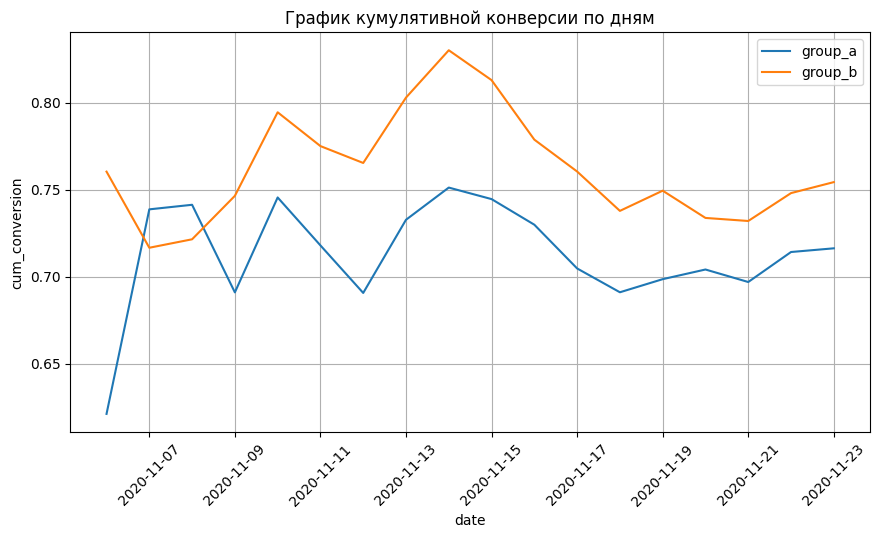

In [22]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=sample_a_daily, ax=ax, label='group_a')
sns.lineplot(x='date', y='cum_conversion', data=sample_b_daily, ax=ax, label='group_b')
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

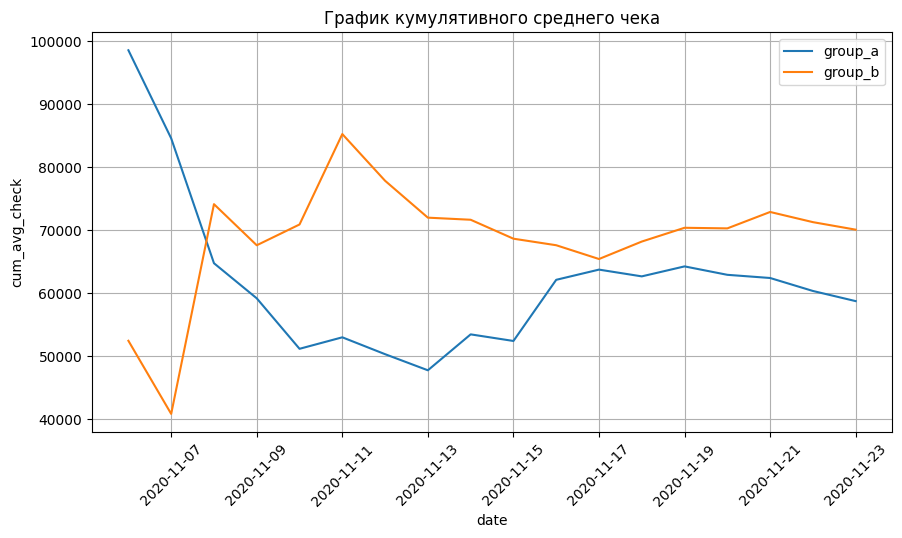

In [23]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_avg_check', data=sample_a_daily, ax=ax, label='group_a')
sns.lineplot(x='date', y='cum_avg_check', data=sample_b_daily, ax=ax, label='group_b')
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

In [7]:
# нулевая и альтернативная гипотезы
H0 = 'Показатели конверсии в группах A и B равны'
H1 = 'Показатель конверсии в группе A меньше чем в группе B'
# уровень значимости
alpha = 0.1
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=([sample_a['transactions'].sum(), sample_b['transactions'].sum()]), #число "успехов"
    nobs=([sample_a['cid'].count(), sample_b['cid'].count()]), #общее число наблюдений
    alternative='smaller'
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.22
Принимаем нулевую гипотезу. Показатели конверсии в группах A и B равны


In [8]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
# уровень значимости
alpha = 0.1
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(sample_a_daily['revenue_sum']/sample_a_daily['transactions_count'])
shapiro_result_b = shapiro(sample_b_daily['revenue_sum']/sample_b_daily['transactions_count'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [10]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки равны'
H1 = 'Ежедневный средний чеки в группе A меньше, чем в группе B'
# уровень значимости
alpha = 0.1
# вычисляем результат теста Манна-Уитни для выборок
results = mannwhitneyu(
    x=sample_a_daily['revenue_sum']/sample_a_daily['transactions_count'],
    y=sample_b_daily['revenue_sum']/sample_b_daily['transactions_count'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.09
Отвергаем нулевую гипотезу. Ежедневные средние чеки равны
Альтернативная гипотеза. H1: Ежедневный средний чеки в группе A меньше, чем в группе B
